In [3]:
from pytorch_lightning.loggers import CometLogger

import torch
from torch import nn
import numpy as np
import torch.nn.functional as F
import pytorch_lightning as pl
from kornia.utils import create_meshgrid
from torch.utils.data import DataLoader, TensorDataset
from einops import rearrange
from torchvision.io import read_image
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from collections import OrderedDict
from kornia.augmentation import RandomAffine, CenterCrop
import cv2 as cv
from utils import show
from models import Homography, NeuralRenderer, SineLayer, Siren

# Apply Homography

In [4]:
H = torch.tensor([[1.0, 0, 0.5],
                 [0, 1.0, 0.5],
                 [0, 0, 1]]).to(model.device)
H_inv = torch.linalg.inv(H)

C,H,W = model.img.size()
x = create_meshgrid(H,W).squeeze().to(model.device)
ones = torch.ones((H,W,1)).to(model.device)
x_hom = torch.concat([x,ones], dim=2)
x_hom = rearrange(x_hom,'H W C -> (H W) C')

x_hom = (H_inv@x_hom.T).T

x_euc = x_hom/x_hom[:,2:]
y = model(x_euc[:,:2])
y = rearrange(y, '(H W) C -> C H W ', H=H,W=W)    
show([model.img,y])
plt.show()

NameError: name 'model' is not defined

In [4]:
def get_coords_dataloader(img):
    C,H,W = img.size()
    img = rearrange(img,'c H W -> (H W) c')

    x = create_meshgrid(H,W).squeeze()
    ones = torch.ones((H,W,1))
    x_hom = torch.concat([x,ones], dim=2)
    x_hom = rearrange(x_hom,'H W C -> (H W) C')
    dataset  = TensorDataset(x_hom, img)
    dataloader = DataLoader(dataset, batch_size=H*W)
    return dataloader
    

class BARF_PL(pl.LightningModule):
    def __init__(self, imgs, pos_enc=False, L=10, barf_c2f = True, video_file = "output.avi"):
        super().__init__()
        #self.mlp = NeuralRenderer(True)
        
        # Positional Encoding
        self.L = L
        self.pos_enc = pos_enc
        self.barf_c2f = barf_c2f
        if pos_enc:
            input_size = 2*2*L
        else:
            input_size = 2
            
            
        self.img = imgs[0]

        # MLP-Model (SIREN)
        self.mlp = Siren(in_features=input_size, out_features=3, hidden_features=256,
                  hidden_layers=3, outermost_linear=True)
        
        # Loss
        self.loss = nn.L1Loss()
        
        # Images 
        self.imgs = imgs
        img = self.img
        C,H,W = self.img.size()
        
        
        # Homographies
        self.homographies = nn.ModuleList([Homography() for _ in imgs])
        
        # Video Writer
        self.out = cv.VideoWriter( video_file, cv.VideoWriter_fourcc('M','J','P','G'), 3, (W,H))


    def forward(self, x):
        #x = x.clone().requires_grad_(True)
        if self.pos_enc:
            x = self.positional_encoding(x)

        return self.mlp(x)[0]

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000)
        return [optimizer], [lr_scheduler]

    def train_dataloader(self):
        #loaders = [self.dataloader_ref] + [get_coords_dataloader(img) for img in imgs[1:]]
        
        return get_coords_dataloader(self.img)

    def val_dataloader(self):
        return get_coords_dataloader(self.img)

    def positional_encoding(self, input): # [B,...,N]
        L = self.L
        shape = input.shape
        freq = 2**torch.arange(L,dtype=torch.float32).to(input.device)*np.pi # [L]
        spectrum = input[...,None]*freq # [B,...,N,L]
        sin,cos = spectrum.sin(),spectrum.cos() # [B,...,N,L]
        input_enc = torch.stack([sin,cos],dim=-2) # [B,...,N,2,L]
        input_enc = input_enc.view(*shape[:-1],-1) # [B,...,2NL]
        
        # coarse-to-fine: smoothly mask positional encoding for BARF
        if self.barf_c2f:
            # set weights for different frequency bands
            start,end = 0,self.trainer.max_epochs
            progress = self.current_epoch
      
            alpha = (progress-start)/(end-start)*L
            k = torch.arange(L,dtype=torch.float32,device=input.device)
            weight = (1-(alpha-k).clamp_(min=0,max=1).mul_(np.pi).cos_())/2
            # apply weights
            shape = input_enc.shape
            input_enc = (input_enc.view(-1,L)*weight).view(*shape)
            
        return input_enc

    def training_step(self, batch, batch_idx):
        
        
        C,H,W = self.img.size()
        x,y = batch
        x_euc = x/x[:,2:]
        y_hat = self(x_euc[:,:2])
        loss = self.loss(y_hat, y)
        
        grid = rearrange(x_euc[:,:2], '(H W) C -> H W C', H=H,W=W).unsqueeze(0) # (1, H, W, 2)


        for i,img in enumerate(self.imgs[1:],1):
            
            T = self.homographies[i]

            x_hom = (T(x.T)).T
            x_euc = x_hom/x_hom[:,2:] # normalize homogeneous coordinates

            y_hat = self(x_euc[:,:2]) # I(H(x))
            y_hat = rearrange(y_hat, '(H W) C -> C H W', H=H,W=W).unsqueeze(0) # (1, H, W, 3)
                        
            y = F.grid_sample(img.unsqueeze(0), grid, align_corners=True)
            
            loss += self.loss(y_hat, y)
        
        self.log('loss', loss.item())
        return loss

    def render_image(self, T):
        
        C,H,W = self.img.size()
        x = create_meshgrid(H,W).squeeze().to(self.device)
        
        ones = torch.ones((H,W,1)).to(self.device)
        x = torch.concat([x,ones], dim=2)
        x = rearrange(x,'H W C -> (H W) C')

        x_hom = (T(x.T)).T
        x_euc = x_hom/x_hom[:,2:]
        y = self(x_euc[:,:2])

        y = rearrange(y, '(H W) C -> C H W ', H=H,W=W)    

        return y

    def on_train_epoch_end(self):
        
        if self.current_epoch % 10 == 0:
            results = []
            for i,T in enumerate(self.homographies):
                print(T.get_H())
                y = self.render_image(T)
                results.append(y)

                frame = rearrange(y, 'C H W -> H W C')    
                frame = frame.detach().cpu().numpy()
                frame = 255*frame
                frame = frame.astype(np.uint8)[:,:,::-1]
                if i == 0:
                    self.out.write(frame)
            show(results)
            show(self.imgs)
            plt.show()
            
#    def on_after_backward(self):
#        # example to inspect gradient information in tensorboard
#        if self.trainer.global_step % 25 == 0:  # don't make the tf file huge
#            params = self.state_dict()
#            for k, v in params.items():
#                grads = v
#                name = k
#                if name.startswith("homographies"):
#                    print(name)
#                    print(grads, v.grad)

                #self.logger.log_histogram(tag="grads", values=grads, global_step=self.trainer.global_step)

torch.Size([3, 250, 250])
torch.Size([3, 250, 250])


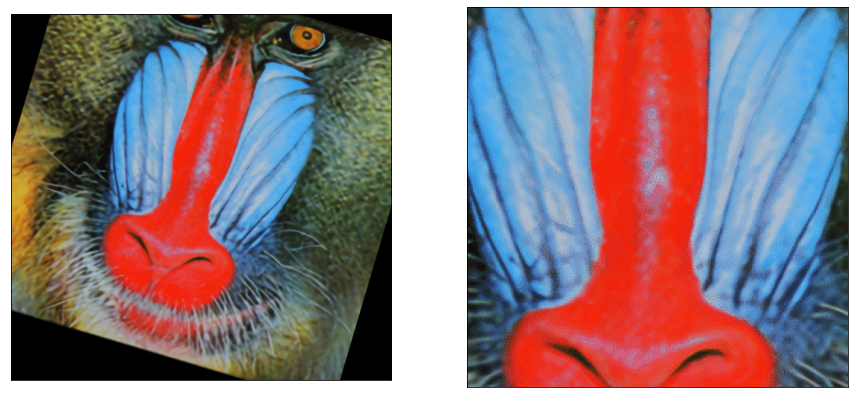

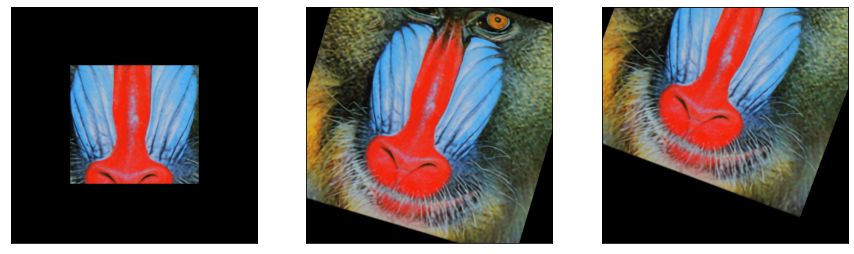

In [5]:
img = read_image("baboon.png", torchvision.io.ImageReadMode.RGB)/255.
aug = RandomAffine((-30., 30.), (0,0.5), p=1.)
center =  CenterCrop((250,250))

C,H,W = img.size()
x = create_meshgrid(H,W).squeeze()
ones = torch.ones((H,W,1))
x_hom = torch.concat([x,ones], dim=2)
x_hom = rearrange(x_hom,'H W C -> C H W')

img_hom1 = aug(img[None,:],).squeeze()
img_hom2 = aug(img[None,:],).squeeze()
img_center = center(img[None,:],).squeeze()

print(center(x_hom).squeeze().size())
print(img_center.size())
show([img_hom1,img_center])

img_ref = img.clone()
img_ref[:,:120,:]= 0
img_ref[:,-120:,:]= 0
img_ref[:,:,:120]= 0
img_ref[:,:,-120:]= 0

img_ref_mask = torch.ones_like(img_ref)
img_ref_mask[:,:120,:]= 0
img_ref_mask[:,-120:,:]= 0
img_ref_mask[:,:,:120]= 0
img_ref_mask[:,:,-120:]= 0

show([img_ref,img_hom1, img_hom2])

In [ ]:
COMET_ML_PROJECT = "barf"
torch.cuda.empty_cache()
experiment_name = "BARF"
    

comet_logger = CometLogger(
    api_key="tMEjeyq5M7v1IPRCvS5fyGyuo",
    workspace="semjon", # Optional
    project_name= COMET_ML_PROJECT, # Optional
    # rest_api_key=os.environ["COMET_REST_KEY"], 
    #save_dir='./segmentation',
    experiment_name=experiment_name, # Optional,
    #display_summary_level = 0
)

imgs = [img_ref.cuda(),img_hom1.cuda(), img_hom2.cuda()]

model = BARF_PL(imgs, pos_enc=True, barf_c2f=True).cuda()
trainer = pl.Trainer(accelerator="gpu", logger=comet_logger,log_every_n_steps=1, max_epochs=3000)
trainer.fit(model)
model.out.release()

CometLogger will be initialized in online mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/monika/anaconda3/envs/ML/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:115: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type       | Params
--------------------------------------------
0 | mlp          | Siren      | 208 K 
1 | loss         | L1Loss     | 0     
2 | homographies | ModuleList | 24    
--------------------------------------------
208 K     Trainable params
0         Non-trainable params
208 K     Total params
0.835     Total estimated model params size (MB)
/home/monika/anaconda3/envs/ML/lib/python3.9/site-packages/pytorch

Training: 0it [00:00, ?it/s]

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.com/semjon/barf/9767ff8f6e21450b9c03520cb558b5c6



tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0', grad_fn=<LinalgMatrixExpBackward0>)
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0', grad_fn=<LinalgMatrixExpBackward0>)
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0', grad_fn=<LinalgMatrixExpBackward0>)


/home/monika/anaconda3/envs/ML/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352657443/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/monika/research/barf/models.py:36: UserWarning: An output with one or more elements was resized since it had shape [1, 3, 3], which does not match the required output shape [1, 1, 3, 3]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352657443/work/aten/src/ATen/native/Resize.cpp:17.)
  H = A.matrix_exp()


[Homography(), Homography(), Homography(), Homography(), Homography()]


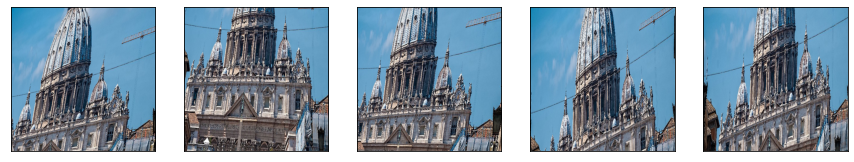

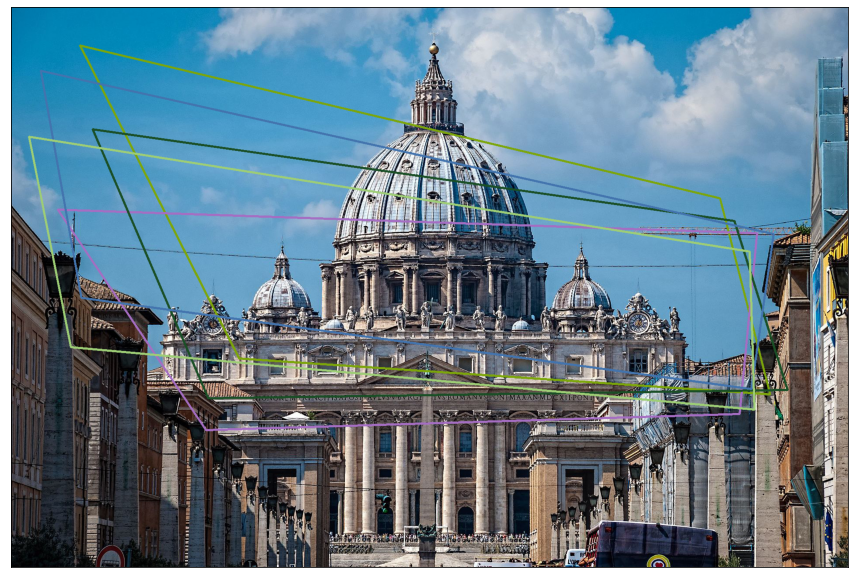

In [2]:
import utils
img = read_image("basilica.jpg", torchvision.io.ImageReadMode.RGB)/255.


img_numpy = rearrange(img*255,'C H W -> H W C')
img_numpy = img_numpy.numpy().astype(np.uint8)
T, w, corners_H = utils.get_random_Warp()

C,H,W = img.size()

img_warps = list(zip(*[utils.get_random_Patch(img) for _ in range(5)]))
warps = list(img_warps[0])
Hs = list(img_warps[1])
print(Hs)
#plt.imshow(img_poly)
show(list(img_warps[0]))
show(utils.draw_patches(img, Hs))

In [60]:
img = read_image("baboon.png", torchvision.io.ImageReadMode.RGB)/255.
aug = RandomAffine((-15., 20.), (0,0.5), p=1.)
center =  CenterCrop((250,250))

C,H,W = img.size()
x = create_meshgrid(H,W).squeeze()
ones = torch.ones((H,W,1))
x_hom = torch.concat([x,ones], dim=2)
x_hom = rearrange(x_hom,'H W C -> (H W) C')
img = rearrange(img,'C H W -> (H W) C')

In [54]:
x.size(),img.size()

(torch.Size([480, 500, 2]), torch.Size([3, 250, 250]))